In [2]:
import os
import glob
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import seaborn

%matplotlib inline

In [3]:
os.chdir("Data")
allFiles = glob.glob("*.zip")

In [4]:
def func_(f):
    tmp = pd.read_csv(zipfile.ZipFile(f).open(f.replace('.zip','.txt')))
    tmp["Year"] = f[3:5]
    return tmp
df = pd.concat(func_(f) for f in allFiles)

In [5]:
df.shape

(749121, 21)

In [6]:
nzip = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson")

In [7]:
nzip.head(2)

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004


In [8]:
df = df[df["ZIP"].isin(nzip["postalCode"].astype(float)) | df["zip"].isin(nzip["postalCode"].astype(float))]

In [9]:
df.Year = pd.to_datetime(df.Year, format="%y").dt.year

In [10]:
df.reset_index(drop=True, inplace=1)

In [11]:
df1 = df[["Year", "ZIP", "EST"]].dropna()
df2 = df[["Year", "zip", "est"]].dropna()
df2.rename(columns={"zip":"ZIP", "est":"EST"}, inplace=True)
df = pd.concat([df1, df2])

In [12]:
df_pivot = df.pivot(index="ZIP", columns="Year", values="EST")

In [13]:
df_pivot.head(2)

Year,1994,1995,1996,1997,1998,1999,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,
10001.0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7141.0,7084.0,7370.0,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002.0,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2269.0,2402.0,2551.0,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0


In [14]:
df_pivot.shape

(244, 19)

In [15]:
df_sd = df_pivot.apply(lambda x: (x - x.mean())/x.std(), axis=1)

In [16]:
df_sd.fillna(0, inplace=1)

In [17]:
df_sd.shape

(244, 19)

In [18]:
Kcluster = KMeans(n_clusters=5).fit(df_sd)
cluster = Kcluster.predict(df_sd)

In [49]:
gen = [i for j in (range(1994, 2000), range(2002, 2015)) for i in j]

In [50]:
len(gen)

19

(1994, 2014)

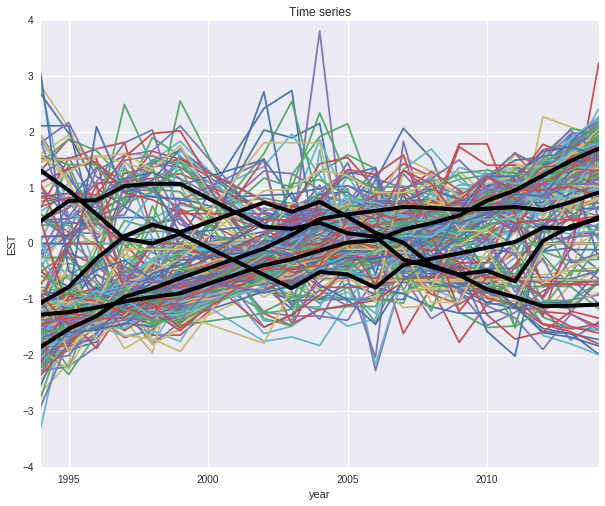

In [52]:
plt.figure(figsize=(10,8))
for i in range(len(df_sd)):
    c = Kcluster.labels_[i]
    plt.plot(gen, df_sd.iloc[i,:19])
for i in range(len(Kcluster.cluster_centers_)):
    plt.plot(gen, Kcluster.cluster_centers_[i], color="black", linewidth=4)
plt.title("Time series")
plt.ylabel("EST")
plt.xlabel("year")
plt.xlim(1994,2014)

In [21]:
AC = AgglomerativeClustering(n_clusters=5, linkage="ward").fit(df_sd.iloc[:,:19])

In [29]:
K_df = pd.DataFrame({"zip":df_sd.index.values, "label":Kcluster.labels_})
A_df = pd.DataFrame({"zip":df_sd.index.values, "label":AC.labels_})

In [30]:
nzip.rename(columns={"postalCode":"zip"}, inplace=1)

In [31]:
nzip["zip"] = pd.to_numeric(nzip["zip"])

In [32]:
df_KA = nzip.merge(KMdf, on="zip").merge(ACdf, on="zip")

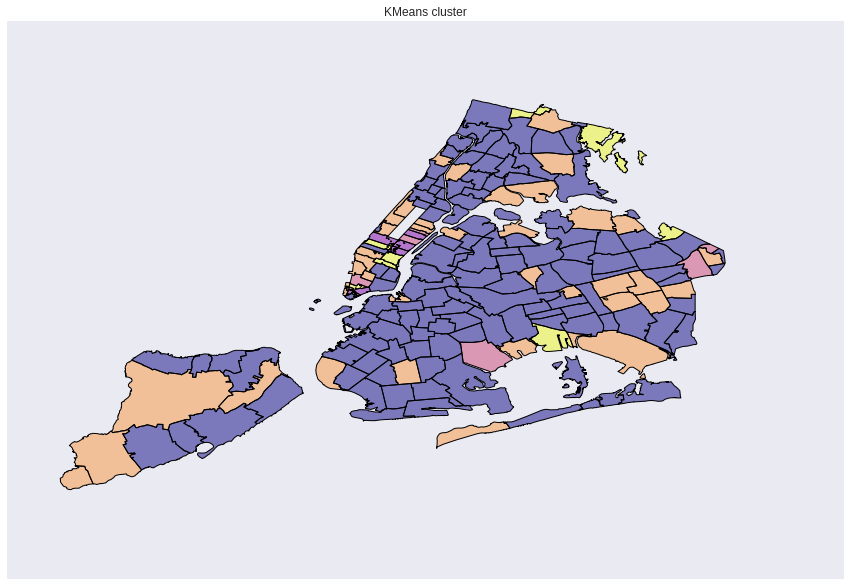

In [36]:
f, ax = plt.subplots(figsize=(15,10))
df_KA.plot(column="label_x", cmap="plasma", figsize=(15,10), ax=ax)
ax.set_title("KMeans cluster")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


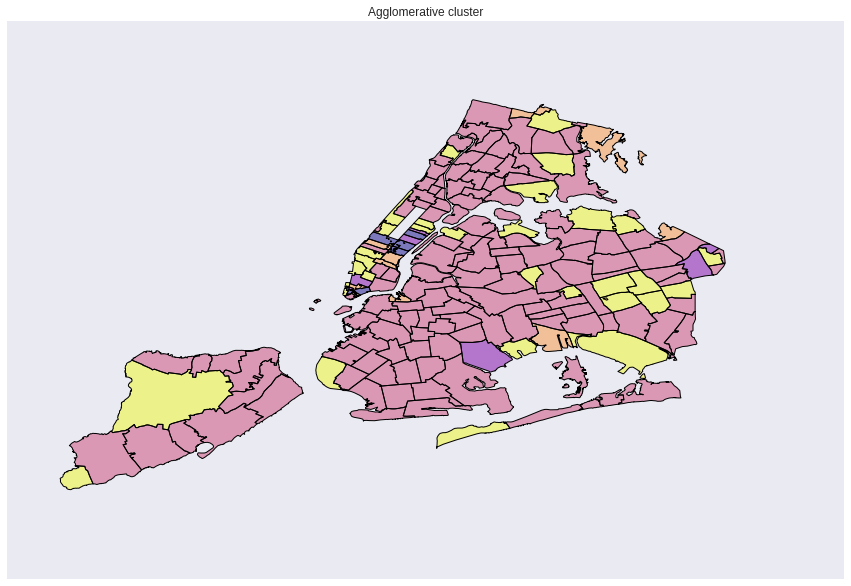

In [37]:
f, ax = plt.subplots(figsize=(15,10))
df_KA.plot(column="label_y", cmap="plasma", figsize=(15,10), ax=ax)
ax.set_title("Agglomerative cluster")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


The both results showed similar pattern. However, there still some differences between them. 

In [ ]:
#@Review: Insufficient comments
#6. Compare the results of the 2 algorithms
#7. attempt an interpretation.